# Step by Step walkthrough of producing a reflectance model with `PyHapke`

In [6]:
from pyhapke import rad_tran
from pyhapke import op_cons
from pyhapke import utils
from importlib import reload
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 100
import os

## Background

We are interested in modelling reflectance of a planetary regolith that is being observed as follows (Figure credits: [Belgacem et al. (2020)](https://ui.adsabs.harvard.edu/abs/2020Icar..33813525B/abstract))

<img src="hapke_geo.png" width="500" align="middle"/>

### The Hapke equation

In the Hapke model, the bi-directional reflectance of a regolith is defined as:

$$r_f(\mu,\mu_0,g) = K \dfrac{\omega}{4}\dfrac{\mu_0}{(\mu + \mu_0)}[(1 + B(g))P(g) + H(\omega,\mu/K)H(\omega,\mu_0/K) - 1]$$

Here (going from left to right):

$r_f$ is the radiance factor, which is the ratio of bidirectional reflectance of a surface to that of a perfectly diffuse surface (Lambertian) illuminated and observed at $i=0$ <br>
$\mu$ is the cosine of the emergence angle $e$ (see geometry of observation above) <br>
$\mu_0$ is the cosine of the incidence angle $i$ <br>
$g$ is the phase angle <br>
$K$ is the porosity coefficient <br>
$\omega$ is the single scattering albedo <br>
$P$ is the particle phase function <br>
$B$ is the backscattering function
$H$ is the Ambartsumian-Chandrasekhar function that accounts for multiply scattered component of the reflection. <br>

**Note:** This model currently does not incorporate 'opposition effects' that are important for small phase angle observations, specifically SHOE ([Hapke (1986)](https://ui.adsabs.harvard.edu/abs/1986Icar...67..264H/abstract)) and CBOE ([Hapke (2002)](https://ui.adsabs.harvard.edu/abs/2002Icar..157..523H/abstract)). 

### The porosity coefficient $K$

$K$ is the porosity coefficient. It is related to the filling factor $\phi$ through 

$$K = \textrm{-ln}(1 - 1.209\phi^{2/3})/1.209\phi^{2/3}$$

The filling factor $\phi$ is the total fraction of volume occupied by particles. The eq. for $r_f$, with $K$ included, is valid only up to the critical point of $\phi < 0.52$ where coherent effects become important. This avoids the difficulty that this equation predicts that the reflectance would become very large when $\phi \rightarrow 0.75$. However this means that the $r_f$ equation with $K$ included is not applicable to solid rocks or extremely compressed powders.

The filling factor $\Phi$ for a mixture with $j$ components is defined as

$$\Phi = \sum_j N_j v_j = \sum_j N_j \frac{4}{3} \pi (\frac{D_j}{2})^3$$

where $N_j$ is the number density (units m$^{-3}$) and $v_j$ is the volume of a single particle/grain of component $j$ of diameter $D_j$.

### The single scattering albedo $\omega$

For a medium that consists of only one type of particle that is large compared to the wavelength, $\omega$ is given by

$$\omega = \dfrac{N\sigma Q_S}{N\sigma Q_E} = \dfrac{Q_S}{Q_E} = Q_s$$

Here, $Q_S$ is the *volume-average scattering efficiency including diffraction*, $Q_s$ is the *volume-average scattering efficiency excluding diffraction* and $Q_E$ is the *volume-average extinction efficiency*. 

**Note**: Here we assume that $Q_E=1$ and $Q_S = Q_s$ for large particles in a medium in which the particles are in contact. Usually, $Q_E$ relates to $K$ and hence can be variable.<br>

Assuming that the scattering efficiency of an equant particle can be described to a sufficient approximation by the equivalent-slab model:

$$\omega = Q_s = S_e + (1 - S_e) \dfrac{(1 - S_i)\Theta}{1 - S_i\Theta}$$

where $S_e$ and $S_i$ are the average Fresnal reflection coefficients for externally and internally incident light.:

$$S_e = 0.0587 + 0.8543 R(0) + 0.0870 R(0)^2$$

$$S_i \approx 1 - \dfrac{1}{n_r}[0.9413 - 0.8543 R(0) - 0.0870 R(0)^2]$$

where $R(0)$ is the *normal specular reflection coefficient*

$$R(0) = \dfrac{(n_r - 1)^2 + n_i^2}{(n_r + 1)^2 + n_i^2}$$

**Note**: Some papers, like [Lapotre et al. (2017)](https://agupubs.onlinelibrary.wiley.com/doi/full/10.1002/2016JE005248), use alternate definitions $S_e$ and $S_i$:

$$S_e = \dfrac{(n_r-1)^2 + n_i^2}{(n_r+1)^2 + n_i^2} + 0.05$$

$$S_i = 1.014 - \dfrac{4}{n_r(n_r+1)^2}$$

$\Theta$ is the *internal-transmission factor* given by (eq. 6.48):

$$\Theta = \dfrac{r_i + \textrm{exp}(-\sqrt{\alpha(\alpha + s)}\langle D \rangle)}{1 + r_i \textrm{exp}(-\sqrt{\alpha(\alpha + s)}\langle D \rangle)}$$

where $r_i = \frac{1 - \sqrt{\dfrac{\alpha}{\alpha + s}}}{1 + \sqrt{\dfrac{\alpha}{\alpha + s}}}$ is the *internal diffusive reflectance*, $\alpha$ is *the absorption coefficient* ($= 4\pi n_i/\lambda$), $s$ is the *internal scattering coefficient inside the particle* and $\langle D \rangle$ is the *effective particle size*. <br>

In the *equivalent-slab approximation*, $\langle D \rangle \approx 0.9 D$ for $n_r$ between 1.3 and 2.0. However, the exact expression is:

$$\langle D \rangle = \dfrac{2}{3} \Big[ n_r^2 - \dfrac{1}{n_r}(n_r^2 - 1)^{3/2}\Big]D$$

### The phase function $P$

The most commonly used empirical phase function is the *Henyey-Greenstein* function. There are one, two and three parameter variants (section 6.3.3 of the Hapke 2012 book). <br>

The single-parameter function is 

$$P_{HG1}(g) =  \dfrac{1 - \xi^2}{(1 + 2\xi \textrm{cos}g + \xi^2)^{3/2}}$$

where $\xi$ is the cosine asymmetry factor, $\xi = - \langle \textrm{cos}g \rangle$

The above equation has only one lobe, whereas the phase functions of most particles are double-lobed. Hence, to represent them two *Henyey-Greenstein* functions of opposite symmetry are required. <br>

The two parameter version is:

$$P_{HG2}(g) = \dfrac{1+c}{2}\dfrac{1 - b^2}{(1 - 2b\textrm{cos}g + b^2)^{3/2}} + \dfrac{1-c}{2}\dfrac{1 - b^2}{(1 + 2b\textrm{cos}g + b^2)^{3/2}}$$

and the three-parameter function is:

$$P_{HG3}(g) = \dfrac{1+c}{2}\dfrac{1 - b_1^2}{(1 - 2b_1\textrm{cos}g + b_1^2)^{3/2}} + \dfrac{1-c}{2}\dfrac{1 - b_2^2}{(1 + 2b_2\textrm{cos}g + b_2^2)^{3/2}}$$

In these expressions the first term describes the backward lobe and the second term describes the forward lobe; the relative strengths of the lobes are determined by $c$, and their shapes by $b$, $b_1$ or $b_2$.

**Note**: The b-parameters are constrained to lie in the range $0 \leq b,b_1,b_2 \leq 1$; there is no constraint on c except that $P_{HG}(g) \geq 0$ everywhere

In the *equivalent-slab approximation* (section 6.5.7 in Hapke 2012), $b$ and $c$ can be calculated as

$$c = \dfrac{\Delta Q_s}{Q_s}$$

$$b = 0.15 + \dfrac{0.05}{(1 + \Delta Q_s/Q_s)^{4/3}}$$

where $\Delta Q_s$ is the *scattering efficiency difference*, which is the difference between the back- and forward-scattering efficiency of a slab and is given by (eq. 6.51 and section 5.6 in Hapke 2012)

$$\Delta Q_s = S_e + (1 - S_e)(1 - S_i)\dfrac{\Psi}{1 - S_i \Psi}$$ 

where $\Psi$ is the *scattering efficiency difference factor* and is given by (eq. 6.31)

$$\Psi = \dfrac{r_i - \textrm{exp}(-\sqrt{\alpha(\alpha + s)}\langle D \rangle)}{1 - r_i \textrm{exp}(-\sqrt{\alpha(\alpha + s)}\langle D \rangle)}$$

Apart, from the *Henyey-Greenstein* phase functions, `PyHapke` also supports two other popular, but simpler, phase functions: `Euler` ($P(g) = 1 - cos(g)$) and `isotropic` ($P(g) = 1$)

### Mixing equations

For an intimate mixture of species, the mixing equations for $\omega$ and $p(g)$ are:

$$\omega = \dfrac{\sum_j N_j \sigma_j Q_{Ej} \omega_j}{\sum_j N_j \sigma_j Q_{Ej}} = \dfrac{\sum_j f_j \sigma_j Q_{Ej} \omega_j}{\sum_j f_j \sigma_j Q_{Ej}}$$

$$p(g) = \dfrac{\sum_j N_j \sigma_j Q_{Ej} \omega_j p_j(g)}{\sum_j N_j \sigma_j Q_{Ej} \omega_j} = \dfrac{\sum_j f_j \sigma_j Q_{Ej} \omega_j p_j(g)}{\sum_j f_j \sigma_j Q_{Ej} \omega_j} $$

Here $N_j$ is the number of particles per unit volume, $f_j = \frac{N_j}{\sum_j N_j}$ is the corresponding number fraction, $\sigma_j = \pi a_j^2$ is the cross-sectional area of a particle and $Q_{Ej}$ is the extinction efficiency of a particle of type $j$.

## Examples

### 1. Single component model

We will plot a water ice reflectance spectrum in this tutorial. 

First, let us set up our planetary regolith using the class `regolith`

In [ ]:
from frostie.pyhapke import regolith
example_one_regolith = regolith()

The `example_one_regolith` object is currently empty, but we can add more information about waht the regolith is made of and how we are observing it.

First, let us define what our regolith is made of. In this example, we only have one component: water. We will need to load the optical constants of water as they are the key input for reflectance modelling. Optical constants of water measured at 120 K, in the near infrared, are available in the Github repository of `FROSTIE`. We will focus on the 1-2.5 $\mu$m wavelength region.

We will use the `load_op_cons` function, which requires a file with three columns, $n$, $k$ and $wavelength$ (in $\mu$m), in that order.

In [ ]:
from frostie.utils import load_op_cons

path_to_water_op_cons = 'data/op_cons/h2o.txt'
n_water, k_water, wav_water = load_op_cons(path_to_water_op_cons, wav_min=1.0, wav_max=2.5)

Let's plot these optical constants to get some insight into water ice's optical behavior. 

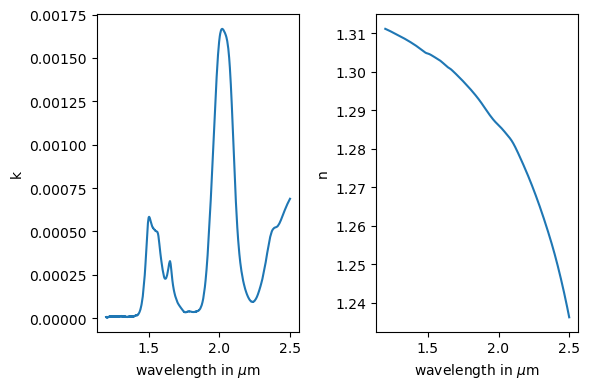

In [11]:
#n_water, k_water, wav_water = op_cons.get_mastrapa_nk(form='Crystalline',temperature=120, start_wav=1.2,end_wav=2.5)

import matplotlib.pyplot as plt

fig, ax = plt.subplots(nrows=1, ncols=2)
ax[0].plot(wav_water,k_water)
ax[0].set_ylabel('k')
ax[0].set_xlabel('wavelength in $\mu$m')
ax[1].plot(wav_water,n_water)
ax[1].set_ylabel('n')
ax[1].set_xlabel('wavelength in $\mu$m')
plt.tight_layout();

In the $k$ spectrum, there are two significant bumps near 1.5 and 2.0 $\mu$m. Since the absorption coefficient $\alpha$ is directly dependent on $k$ ($\alpha = 4\pi k/\lambda$), we expect to see strong water absorption features in the reflectance spectrum around 1.5 and 2.0 $\mu$m as well

We will create a dictionary to hold all information about water that our model needs, including the optical constants, grain size $D$, phase function $P$ and density of internal scatterers $s$. For phase function, `PyHapke` provides four options, `isotropic`, `Euler`, `HG1` (one parameter Henyey-Greenstein) and `HG2`. We will use `HG2` in this example, since its the most versatile. We will also $D = 100$ microns sized grains, which are clear, so $s = 0$. 

In [ ]:
water = {'n':n_water, 'k':k_water, 'wav':wav_water, 'D':100, 'P':'HG2', 's':0}

example_one_regolith.add_components([water])

Next, let us set-up the observation by providing the observation geometry angles, $i$, $e$ and $g$, in degrees. 

In [ ]:
example_one_regolith.obs_geo(i=45,e=45,g=90)

Next, let us define the porosity of the regolith. Porosity is defined as the fraction of volume in a regolith that is empty, which in case of airless bodies is vacuum. Hapke model permits a range of [0.48, 1) for porosity of the regolith. If porosity gets smaller than $\sim 0.48$, the grains in the regolith get close enough that diffraction effects start to matter, which the Hapke model currently does not incorporate.

In [ ]:
example_one_regolith.porosity(p=0.9)

We will assume no backscattering enhancement for now, so let's set the $B$ parameter to 0

In [ ]:
example_one_regolith.backscattering(B=0)

We are ready to model the reflectance of our regolith `example_one_regolith`

In [ ]:
example_one_regolith.calculate_reflectance()

Let us plot this reflectance spectrum

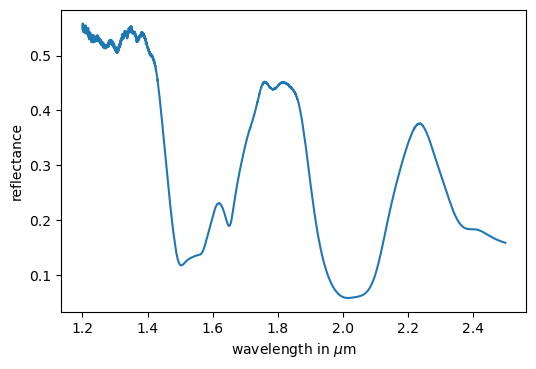

In [15]:
plt.figure()
plt.plot(example_one_regolith.wav_ref, example_one_regolith.ref)
plt.ylabel('reflectance')
plt.xlabel('wavelength in $\mu$m');


'''
mu_0 = np.cos(np.deg2rad(45))   # cosine of the incidence angle
mu = np.cos(np.deg2rad(45))   # cosine of the emergence angle
g = 90 # phase angle
s = 0    # internal scattering coefficient
B = 0    # no backscattering
K = 1.0    # porosity coefficient
log10D = 2.0   # log10 of the grain size
p_type = 'HG2'    # type of phase function (options are 'isotropic','Euler', 'HG1' (one parameter Henyey-Greenstein) and 'HG2')

water_dict = {'n':n_water,'k':k_water,'wav':wav_water,'log10D':log10D, 'p_type':'HG2'}

param_dict = {'mu_0':mu_0,'mu':mu,'g':g,'B':B,'K':K,'s':s,'comp':water_dict}

model, wav_model = rad_tran.one_comp(param_dict)

plt.figure()
plt.plot(wav_model, model)
plt.ylabel('reflectance')
plt.xlabel('wavelength in $\mu$m');
'''

Great! The reflectance spectrum looks good, with prominent absorption features near 1.5 and 2.0 microns as we expected from observing $k$ earlier

### 2. Multiple component model

Now let's look an example of modelling reflectance of a regolith with three components - water ice, carbon dioxide ice, and sulfur dioxide ice - in the 1 - 2.5 $\mu$m wavelength region. 

As in the previous example, we will initialize a `regolith` object

In [ ]:
example_two_regolith = regolith()

Next, we will load the optical constants of the three components

In [ ]:
path_to_h2o_op_cons = 'data/op_cons/h2o.txt'
n_h2o, k_h2o, wav_h2o = load_op_cons(path_to_h2o_op_cons, wav_min=1.0, wav_max=2.5)

path_to_co2_op_cons = 'data/op_cons/co2.txt'
n_co2, k_co2, wav_co2 = load_op_cons(path_to_co2_op_cons, wav_min=1.0, wav_max=2.5)

path_to_so2_op_cons = 'data/op_cons/so2.txt'
n_so2, k_so2, wav_so2 = load_op_cons(path_to_so2_op_cons, wav_min=1.0, wav_max=2.5)

Let's plot these optical constants to get an intuition of how their absorption strength compares to each other 

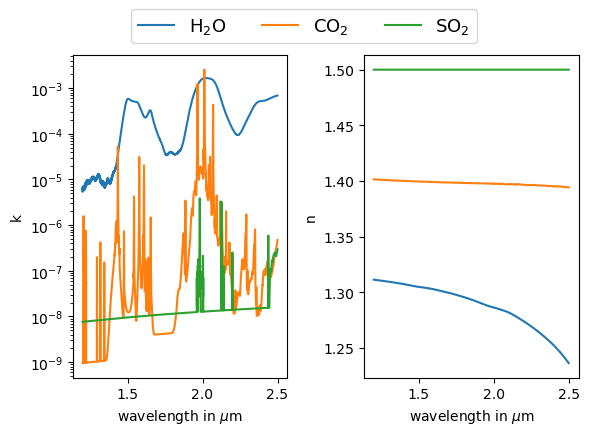

In [21]:
'''
n_water, k_water, wav_water = op_cons.get_mastrapa_nk(form='Crystalline',temperature=120, start_wav=1.2,end_wav=2.5)
n_co2, k_co2, wav_co2 = op_cons.get_co2_sshade(1.2, 2.5)
n_so2, k_so2, wav_so2 = op_cons.get_so2_sshade(1.2, 2.5)
'''

fig, ax = plt.subplots(nrows=1, ncols=2)
ax[0].plot(wav_water,k_water, label='H$_2$O')
ax[0].plot(wav_co2,k_co2, label='CO$_2$')
ax[0].plot(wav_so2, k_so2, label='SO$_2$')
ax[0].set_ylabel('k')
ax[0].set_yscale('log')
ax[0].set_xlabel('wavelength in $\mu$m')
ax[1].plot(wav_water,n_water, label='H$_2$O')
ax[1].plot(wav_co2,n_co2, label='CO$_2$')
ax[1].plot(wav_so2, n_so2, label='SO$_2$')
ax[1].set_ylabel('n')
ax[1].set_xlabel('wavelength in $\mu$m')

# common legend for all subplots

handles, labels = ax[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center', ncol=3, bbox_to_anchor=(0.515, 1.1), fontsize=13)
plt.tight_layout();

Although CO$_2$ has a rich $k$ spectrum, its at least a couple of orders of magnitude weaker than water's $k$ spectrum in most places. SO$_2$ seems to be the weakest of the three, with limited features.

Let's now add these three components to our `example_two_regolith` object. Since there are more than one component in this regolith, we will need to also provide their abundance fractions as input. We will keep $D$, $P$ and $s$ the same as last example

In [ ]:
f = 1.0/3    # equal abundance fraction for all three components

h2o = {'n':n_h2o, 'k':k_h2o, 'wav':wav_h2o, 'D':100, 'P':'HG2', 's':0, 'f':f}
co2 = {'n':n_co2, 'k':k_co2, 'wav':wav_co2, 'D':100, 'P':'HG2', 's':0, 'f':f}
so2 = {'n':n_so2, 'k':k_so2, 'wav':wav_so2, 'D':100, 'P':'HG2', 's':0, 'f':f}

example_two_regolith.add_components([water, co2, so2])

Next, we set up the observation geometry, porosity and backscattering.

In [ ]:
example_two_regolith.obs_geo(i=45,e=45,g=90)
example_two_regolith.porosity(p=0.9)
example_two_regolith.backscattering(B=0)

Finally, we need to decide the mixing mode of our components, i.e., whether they are mixed in an `intimate` way (also called salt-and-pepper model) or in a `linear` way (also called 'areal' model), as illustrated below

<img src="intimate_vs_linear.png" width="500" align="middle"/>

Let's choose intimate mixing for now, as modelling the non-linear effects of mixing is the strength of Hapke model

In [ ]:
example_two_regolith.mixing_mode('intimate')

We are ready to model the reflectance spectrum of `example_two_regolith`!

In [ ]:
example_two_regolith.calculate_reflectance()

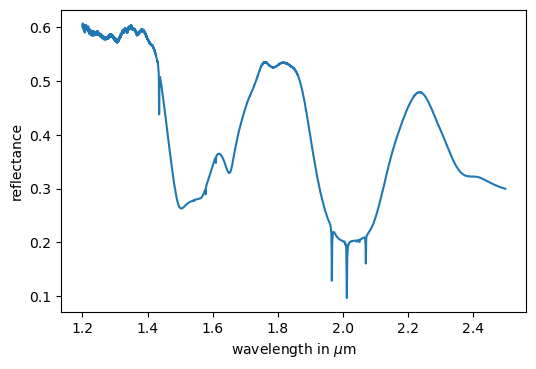

In [24]:
plt.figure()
plt.plot(example_two_regolith.wav_ref, example_two_regolith.ref)
plt.ylabel('reflectance')
plt.xlabel('wavelength in $\mu$m')

'''
mu_0 = np.cos(np.deg2rad(45))   # cosine of the incidence angle
mu = np.cos(np.deg2rad(45))   # cosine of the emergence angle
g = 90 # phase angle
s = 0    # internal scattering coefficient
B = 0    # no backscattering
K = 1.0    # porosity coefficient
log10D = 2.0   # log10 of the grain size
p_type = 'HG2'    # type of phase function (options are 'isotropic','Euler', 'HG1' (one parameter Henyey-Greenstein) and 'HG2')

n_h2o, k_h2o, wav_h2o = op_cons.get_mastrapa_nk(form='Crystalline',temperature=120, start_wav=1.2,end_wav=2.5)
n_co2, k_co2, wav_co2 = op_cons.get_co2_sshade(1.2, 2.5)
n_so2, k_so2, wav_so2 = op_cons.get_so2_sshade(1.2, 2.5)

h2o_dict = {'n':n_h2o, 'k':k_h2o, 'wav':wav_h2o, 'log10D':log10D, 'p_type':'HG2', 'f':1.0/3}
co2_dict = {'n':n_co2, 'k':k_co2, 'wav':wav_co2, 'log10D':log10D, 'p_type':'HG2', 'f':1.0/3}
so2_dict = {'n':n_so2, 'k':k_so2, 'wav':wav_so2, 'log10D':log10D, 'p_type':'HG2', 'f':1.0/3}

param_dict = {'mu_0':mu_0,'mu':mu,'g':g,'B':B,'K':K,'s':s,'comp_dict_list':[h2o_dict, co2_dict, so2_dict]}

model, wav_model = rad_tran.multi_comp_IM(param_dict, matched_axes=False, constant_D=True)

plt.figure()
plt.plot(wav_model, model)
plt.ylabel('reflectance')
plt.xlabel('wavelength in $\mu$m');
'''

This reflectance spectrum of a water, carbon dioxide and sulfur dioxide mixture is pretty similar to the water ice reflectance spectrum from the previous example, except for sharp absorption features caused by the two oxides. This makes sense as water's $k$ spectrum is much stronger compared to the two oxides, so it is expected to dominate the continuum of the mixture spectrum.